# Covid Impact Analysis - Part 2


In [2]:
import numpy as np
import pandas as pd
import censusdata
#from tabulate import tabulate
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)

import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150 #set figure size

from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
#import plotly.plotly as py
import plotly.graph_objs as go
from us_state import *
import plotly.figure_factory as ff
import networkx as nx
import plotly.express as px
#import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Download Census Dataset

Referrencing https://towardsdatascience.com/mapping-us-census-data-with-python-607df3de4b9c:
* ‘acs5’ refers to the 5 Year American Community Survey and designates the database we are downloading from.
* 2015 is the year that we are getting data from
* censusdata.censusgeo([(‘state’, ‘36’), (‘county’, ‘*’)]) defines the geography we are interested in. The ‘36’ value is the FIPS (Federal Information Processing Standards) code for New York state while the ‘*’ means we want every county. To look up your own state or county FIPS code refer to the Wikipedia page.
* [‘B08301_001E’, ‘B08301_010E’] this is a list referring to the specific two tables that we are interested in. Note that these were located beforehand using the search function of censusdata.


In [3]:
# census = censusdata.download('acs5', 2015,
#            censusdata.censusgeo([('state', '*'), ('county', '*')]),
#            ['B00001_001E','B01001_001E'])

#['B08301_001E', 'B08301_010E']
census = censusdata.download('acs5', 2019,
           censusdata.censusgeo([('state', '06'),
                                 ('county', '*')]),
          ['B02001_001E', 'B02001_002E', 'B02001_003E',
           'B02001_004E', 'B02001_005E',
           'B02001_006E', 'B02001_007E',
           'B02001_008E', 'B02001_009E',
           'B02001_010E',
          ])
ethnicityColumnNames = ['Total', 'White', 'Black or African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawiian and Other Pacific Islander', 'Some other race', 'Two or more races', 'Two races including some other race', 'Two races excluding some other race and three or more races']

In [4]:
def parseFIPS(s):
    p = str(s).split(' ')
    stateID = p[-2][-3:-1]
    countyID = p[-1][-3:]
    return stateID + countyID
census.columns = ethnicityColumnNames
census.head()

,Total,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawiian and Other Pacific Islander,Some other race,Two or more races,Two races including some other race,Two races excluding some other race and three or more races
"Merced County, California: Summary level: 050, state:06> county:047",271382,149434,8645,2501,20349,654,78735,11064,4123,6941
"Mariposa County, California: Summary level: 050, state:06> county:043",17420,15402,253,332,210,53,415,755,45,710
"Modoc County, California: Summary level: 050, state:06> county:049",8907,7976,136,372,99,9,111,204,43,161
"Contra Costa County, California: Summary level: 050, state:06> county:013",1142251,637904,99642,5506,190983,5631,124629,77956,14659,63297
"Inyo County, California: Summary level: 050, state:06> county:027",17977,14170,153,2028,350,34,392,850,232,618


In [5]:
#process the dataframe
# column_names = ['total_transpo', 'total_public_transpo']
# census.columns = column_names
# census['percent_public_transpo'] = census.apply(
#    lambda row: row['total_public_transpo']/row['total_transpo'], axis = 1)
new_indices = []
county_names = []
state = []
for index in census.index.tolist():
        new_index = index.geo[0][1] + index.geo[1][1]
        new_indices.append(new_index)
        county_name = index.name.split(',')[0].strip()
        temp = index.name.split(';')[0]
        state_name = index.name.split(',')[1].strip()
        county_names.append(county_name)
        state.append(state_name)
#census.index = new_indices
census['county'] = county_names
census['state'] = state
oldIndex = census.index
newIndex = [parseFIPS(s) for s in oldIndex]
census['fips'] = newIndex
census = census.set_index('fips') #make fips as index

In [6]:
#census['county_name'] = census['county_name'].str.replace(' County', '')
census.head()

,Total,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawiian and Other Pacific Islander,Some other race,Two or more races,Two races including some other race,Two races excluding some other race and three or more races,county,state
fips,,,,,,,,,,,,
06047,271382,149434,8645,2501,20349,654,78735,11064,4123,6941,Merced County,California
06043,17420,15402,253,332,210,53,415,755,45,710,Mariposa County,California
06049,8907,7976,136,372,99,9,111,204,43,161,Modoc County,California
06013,1142251,637904,99642,5506,190983,5631,124629,77956,14659,63297,Contra Costa County,California
06027,17977,14170,153,2028,350,34,392,850,232,618,Inyo County,California


## Download US Covid and County Dataset
Dataset: https://www.kaggle.com/headsortails/covid19-us-county-jhu-data-demographics

In [38]:
us_covid = pd.read_csv('./data/covid_us_county.csv', dtype={"fips": str})
us_county = pd.read_csv('./data/us_county.csv', dtype={"fips": str})
print('Covid dataset is updated to:',max(us_covid.date))

Covid dataset is updated to: 2021-05-10


In [39]:
ca_covid = us_covid.loc[us_covid['state_code'] == 'CA']
ca_covid.head()

,fips,county,state,lat,long,date,cases,state_code,deaths
93575,6001,Alameda,California,37.65,-121.89,2020-01-22,0,CA,0
93576,6001,Alameda,California,37.65,-121.89,2020-01-23,0,CA,0
93577,6001,Alameda,California,37.65,-121.89,2020-01-24,0,CA,0
93578,6001,Alameda,California,37.65,-121.89,2020-01-25,0,CA,0
93579,6001,Alameda,California,37.65,-121.89,2020-01-26,0,CA,0


In [65]:
#Merge us_county and census dataset
us_county['state'] = us_county['state_code'].map(abbrev_us_state)
df1 = pd.merge(census, us_county, on=["state","county",],how='right')
print('us_county data shape before merge:',us_county.shape)
print('census data shape before merge:',census.shape)
print('Joining by State and County:',df1.shape)

us_county data shape before merge: (3220, 11)
census data shape before merge: (58, 12)
Joining by State and County: (3220, 21)


In [66]:
ca_covid.dropna(inplace=True)
ca_covid=ca_covid.drop(columns=['state','lat','long','county','state_code'])

In [60]:
ca_covid.head()

,fips,date,cases,deaths
93575,6001,2020-01-22,0,0
93576,6001,2020-01-23,0,0
93577,6001,2020-01-24,0,0
93578,6001,2020-01-25,0,0
93579,6001,2020-01-26,0,0


In [61]:
df = pd.merge(ca_covid, df1, on=["fips"])
print('us_county data shape before merge:',df1.shape)
print('us_covid data shape before merge:',us_covid.shape)
print('Joining by State and County:',df.shape)

us_county data shape before merge: (3220, 21)
us_covid data shape before merge: (1587450, 9)
Joining by State and County: (27550, 24)


In [62]:
df['fips']=df['fips'].apply(lambda x: str(str(x).zfill(5)))

In [61]:
df.head()

,fips,date,cases,deaths,Total,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawiian and Other Pacific Islander,Some other race,Two or more races,Two races including some other race,Two races excluding some other race and three or more races,county,state,state_code,male,female,median_age,population,female_percentage,lat,long
0,06001,2020-01-22,0,0,1.66e+06,670364.0,175751.0,11120.0,499382.0,13900.0,179244.0,106993.0,20746.0,86247.0,Alameda County,California,CA,807171,836529,37.4,1643700,50.89,37.65,-121.89
1,06001,2020-01-23,0,0,1.66e+06,670364.0,175751.0,11120.0,499382.0,13900.0,179244.0,106993.0,20746.0,86247.0,Alameda County,California,CA,807171,836529,37.4,1643700,50.89,37.65,-121.89
2,06001,2020-01-24,0,0,1.66e+06,670364.0,175751.0,11120.0,499382.0,13900.0,179244.0,106993.0,20746.0,86247.0,Alameda County,California,CA,807171,836529,37.4,1643700,50.89,37.65,-121.89
3,06001,2020-01-25,0,0,1.66e+06,670364.0,175751.0,11120.0,499382.0,13900.0,179244.0,106993.0,20746.0,86247.0,Alameda County,California,CA,807171,836529,37.4,1643700,50.89,37.65,-121.89
4,06001,2020-01-26,0,0,1.66e+06,670364.0,175751.0,11120.0,499382.0,13900.0,179244.0,106993.0,20746.0,86247.0,Alameda County,California,CA,807171,836529,37.4,1643700,50.89,37.65,-121.89


## Network Graph
Referrencing: https://towardsdatascience.com/census-geography-with-networkx-fe2aa6c8ab16

County Adjacency Dataset: https://data.nber.org/data/county-adjacency.html

* Nodes — Each node will represent and individual county in New York state. They will be identified by their FIPS (Federal Information Processing Standards) number. Additionally, each node will store the natural language name of the County as well as the % use of public transit.
* Edges — Two nodes will share an edge if they are geographically adjacent on the map


In [71]:
#filter CA data
#df_ca = df[df['state_code']=='CA']
df_group = df.groupby('fips',as_index=False)[['cases','deaths']].sum()
df_group.head()

,fips,cases,deaths
0,6001,14472607,231775
1,6003,13983,0
2,6005,531358,7510
3,6007,1904263,28413
4,6009,308289,7241


In [18]:
def process_counties(df):
    final_list = []
    for index, row in df.iterrows():
        node = (str(row['fips']), 
          {'percent_public_transpo': row['percent_public_transpo'],
           'county_name': row['county']})
        final_list.append(node)
    return final_list
# We’ll define a function to turn the dataframe into a list of tuples 
# while removing any mirrored or self-joined edges.
def create_tuples(df):
    all_tuples = list(df.itertuples(index=False, name=None))
    final_tuples = []
    for tuple in all_tuples:
        if (tuple[1],tuple[0]) not in final_tuples:
            if tuple[1] != tuple[0]:
                final_tuples.append((str(tuple[0]),str(tuple[1])))
    return final_tuples

def draw_graph(G):
    plt.close()
    nx.draw_spring(G, with_labels=True, font_weight='bold',node_size=200,font_size=8)
    plt.show()
    return

In [72]:
# G = nx.Graph()
# county_FIPS = process_counties(df_ca)
# G.add_nodes_from(county_FIPS)
# adj_df = pd.read_csv('./data/county_adjacency2010.csv')
# county_FIPS_list = list(df_ny.fips)
# adj_df = adj_df[adj_df['fipscounty'].isin(county_FIPS_list)]
# adj_df = adj_df[adj_df['fipsneighbor'].isin(county_FIPS_list)]
# # remove all columns except the FIPS codes
# adj_df = adj_df[['fipscounty', 'fipsneighbor']]
# fips_tuples = create_tuples(adj_df)
# G.add_edges_from(fips_tuples)
#draw_graph(G)

## Mobility Flow
Referrencing: https://www.kaggle.com/headsortails/covid19-us-county-jhu-data-demographics

In [72]:
# #fips of 2 counties are missing (Dukes and Nantucket, Kansas City)
# #quick fix for now
# us_covid = us_covid[us_covid.fips.notnull()]
# us_covid['fips'] = us_covid['fips'].astype(object)
# us_county['fips'] = us_county['fips'].astype(object)

# #add popultation from second csv
# us_covid = us_covid.merge(us_county[['fips', 'population']], on = ['fips'], how = "left")

# #keep latest date only
# us_cum = us_covid.sort_values(by = ['county', 'state', 'date'], ascending = [True, True, False])
# us_cum = us_cum.drop_duplicates(subset = ['county', 'state'], keep = "first")

# #save a copy
# counties_us = us_cum.copy()

# #groupby State
# us_cum = us_cum.groupby(['state', 'date'], as_index=False)['cases', 'deaths', 'population'].sum()

# us_cum['population'] = us_cum['population'].astype(int)

# #rounding population to millions with 2 digits, and creating two new columns
# us_cum['population'] = round((us_cum['population']/1000000),2)
# us_cum = us_cum.rename(columns = {'population': 'Population (million)'})
# us_cum['Cases per Million'] = round((us_cum['cases']/us_cum['Population (million)']),2)
# us_cum['Deaths per Million'] = round((us_cum['deaths']/us_cum['Population (million)']),2)

# #remove states with missing population
# us_cum = us_cum[(us_cum['Population (million)'] != 0)]

In [73]:
# us_cum = us_cum.sort_values(by = "Deaths per Million", ascending = False).reset_index(drop=True)
# us_cum.head(10).style.background_gradient(cmap='Reds', subset = ['Deaths per Million'])

In [5]:
def downloadFlowCSV(year, month, day):
    '''
    downloads the flow data for a given day and loads into a dataframe
    uses daily, county2county data
    '''
    # download file to data directory
    date_str = '{0}_{1:02d}_{2:02d}'.format(year, month, day)
    command = 'wget -O data/daily_county2county_' + date_str + '.csv https://raw.githubusercontent.com/GeoDS/COVID19USFlows/master/daily_flows/county2county/daily_county2county_' + date_str + '.csv'
    ! $command
    df = pd.read_csv('data/daily_county2county_' + date_str + '.csv')
    return df

def getFlows(df):
    '''
    produces a dict of a dict of flows
    i.e. origin_fips : destination_fips : population_flow_rate
    ex) 1001 : 1003 : 411.0
    df: the full daily, county2county data frame
    returns: dict of a dict of floats
    '''
    flows = {}
    origin_fips = set(df['geoid_o'])
    for o_fips in origin_fips:
        o_df = df[df['geoid_o'] == o_fips]
        d_fips_to_flow = {int(x['geoid_d']): x['pop_flows'] for i,x in o_df[['geoid_d', 'pop_flows']].iterrows()}
        flows[o_fips] = d_fips_to_flow
    return flows
# might be useful for plotting?
def getCentroid(df):
    '''
    parses out the centroid of each county from the dataframe
    i.e. origin_fips : (longitude, latitude)
    df: the full daily, county2county data frame
    returns: dict of tuples
    '''
    centroids = {}
    origin_fips = set(df['geoid_o'])
    for o_fips in origin_fips:
        o_df = df[df['geoid_o'] == o_fips].iloc[0]
        centroids[o_fips] = (o_df['lng_o'], o_df['lat_o'])
    return centroids

In [191]:
# example
df = downloadFlowCSV(2020, 8, 31)

--2021-05-31 10:47:24--  https://raw.githubusercontent.com/GeoDS/COVID19USFlows/master/daily_flows/county2county/daily_county2county_2020_08_31.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62147930 (59M) [text/plain]
Saving to: ‘data/daily_county2county_2020_08_31.csv’

data/daily_county2c 100%[===================>]  59.27M  37.3MB/s    in 1.6s    

2021-05-31 10:47:26 (37.3 MB/s) - ‘data/daily_county2county_2020_08_31.csv’ saved [62147930/62147930]



**Filter out CA covid data on a specific date**

In [192]:
us_covid = pd.read_csv('./data/covid_us_county.csv', dtype={"fips": str})
us_county = pd.read_csv('./data/us_county.csv', dtype={"fips": str})
print('Covid dataset is updated to:',max(us_covid.date))
ca_covid = us_covid.loc[us_covid['state_code'] == 'CA']
ca_covid.head()

Covid dataset is updated to: 2021-05-10


,fips,county,state,lat,long,date,cases,state_code,deaths
93575,6001,Alameda,California,37.65,-121.89,2020-01-22,0,CA,0
93576,6001,Alameda,California,37.65,-121.89,2020-01-23,0,CA,0
93577,6001,Alameda,California,37.65,-121.89,2020-01-24,0,CA,0
93578,6001,Alameda,California,37.65,-121.89,2020-01-25,0,CA,0
93579,6001,Alameda,California,37.65,-121.89,2020-01-26,0,CA,0


In [193]:
#filter specific date
ca_covid = ca_covid[ca_covid.date=='2020-08-31']
ca_covid.head()

,fips,county,state,lat,long,date,cases,state_code,deaths
93797,6001,Alameda,California,37.65,-121.89,2020-08-31,18187,CA,258
94272,6003,Alpine,California,38.60,-119.82,2020-08-31,2,CA,0
94747,6005,Amador,California,38.45,-120.66,2020-08-31,280,CA,14
95222,6007,Butte,California,39.67,-121.60,2020-08-31,2026,CA,23
95697,6009,Calaveras,California,38.21,-120.55,2020-08-31,236,CA,2


In [194]:
#flows = getFlows(df)
#centroid = getCentroid(df)

In [195]:
#filter out california
df_ca = df.loc[(df['geoid_o']>=6000) & (df['geoid_o']<7000) & (df['geoid_d']>=6000) 
               & (df['geoid_d']<7000) & (df['geoid_d'] !=df['geoid_o']) ]#& (df['pop_flows'] > 100)

In [196]:
graph = nx.from_pandas_edgelist(df_ca, source = 'geoid_o', target = 'geoid_d',
                        create_using = nx.Graph()) #edge_attr = 'pop_flows',

In [197]:
graph.nodes

NodeView((6061, 6013, 6037, 6059, 6001, 6017, 6019, 6029, 6065, 6067, 6071, 6073, 6075, 6081, 6089, 6095, 6097, 6099, 6107, 6113, 6011, 6033, 6039, 6047, 6053, 6077, 6101, 6035, 6051, 6111, 6063, 6015, 6023, 6031, 6085, 6007, 6041, 6045, 6083, 6055, 6079, 6093, 6087, 6103, 6109, 6115, 6021, 6009, 6057, 6005, 6043, 6069, 6049, 6091, 6105, 6025, 6027, 6003))

In [198]:
df_ca['pop_flows'].describe()

count      2552.00
mean       2743.10
std       16160.73
min          15.00
25%          83.00
50%         261.00
75%         939.00
max      446501.00
Name: pop_flows, dtype: float64

In [199]:
centroid = getCentroid(df_ca)

**Node Size**: number of confirmed cases
**Node Color**: magnitude of mobility flow
**Node Label**: county name

In [200]:
cases = {}
for i in df_ca.geoid_d.unique():
    temp = ca_covid[ca_covid.fips==str(i)].cases.values
    cases[i] = temp[0]
flows={}
for i in df_ca.geoid_d.unique():
    temp = df_ca[df_ca.geoid_d==i].pop_flows.values
    flows[i] = temp[0]
sizes = [0.01 * cases[iata] for iata in graph.nodes]
node_color = [flows[i] for i in graph.nodes]

In [201]:
labels = {}
for i in df_ca.geoid_o.unique():
    try:
        temp = ca_covid[ca_covid.fips==str(i)].county.values
        labels[i] = temp[0]
    except:
        labels[i] = ''
#labels = [labels_dict[iata] for iata in graph.nodes]

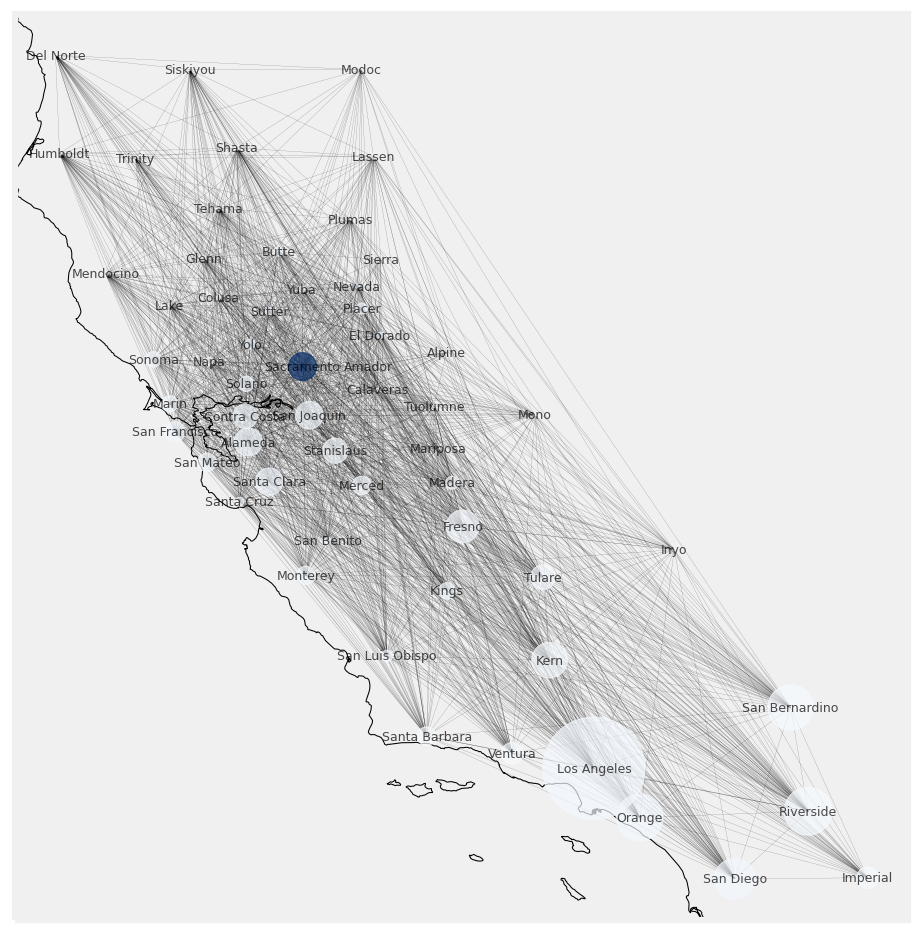

In [203]:
# Map projection
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines()
# Extent of continental US.
#ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(graph, ax=ax,
                 font_size=6,
                 alpha=.7,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=centroid,
                 node_color=node_color,
                 cmap=plt.cm.Blues)